#**Aula 5:**

- Tratamento de outliers;

- Intervalo de confiança;

- Validação cruzada de encadeamento direto;

- Métricas de performance

In [1]:
#importando as bibliotecas:
import pandas as pd
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Configurando os gráficos:
mpl.rcParams['font.size'] = 14
mpl.rcParams['figure.figsize'] = (10,6)

In [3]:
url = 'https://github.com/vqrca/bootcamp_alura_aulas/blob/main/Modulo_3/dados_covid_sp.zip?raw=true'

In [4]:
#Importando os dados:
dados = pd.read_csv(url, sep = ';', compression='zip')
dados.head()

,nome_munic,codigo_ibge,dia,mes,datahora,casos,casos_novos,casos_pc,casos_mm7d,obitos,obitos_novos,obitos_pc,obitos_mm7d,letalidade,nome_ra,cod_ra,nome_drs,cod_drs,pop,pop_60,area,map_leg,map_leg_s,latitude,longitude,semana_epidem
0,Adamantina,3500105,25,2,2020-02-25,0,0,"0,000000e+00","0,0000000",0,0,"0,000000e+00","0,0000000","0,0000000000",RA de Presidente Prudente,9,Marília,5,33894,7398,41199,0,8.0,"-21,6820","-51,0737",9
1,Adolfo,3500204,25,2,2020-02-25,0,0,"0,000000e+00","0,0000000",0,0,"0,000000e+00","0,0000000","0,0000000000",RA de São José do Rio Preto,14,São José do Rio Preto,15,3447,761,21106,0,8.0,"-21,2325","-49,6451",9
2,Aguaí,3500303,25,2,2020-02-25,0,0,"0,000000e+00","0,0000000",0,0,"0,000000e+00","0,0000000","0,0000000000",RA de Campinas,4,São João da Boa Vista,14,35608,5245,47455,0,8.0,"-22,0572","-46,9735",9
3,Águas da Prata,3500402,25,2,2020-02-25,0,0,"0,000000e+00","0,0000000",0,0,"0,000000e+00","0,0000000","0,0000000000",RA de Campinas,4,São João da Boa Vista,14,7797,1729,14267,0,8.0,"-21,9319","-46,7176",9
4,Águas de Lindóia,3500501,25,2,2020-02-25,0,0,"0,000000e+00","0,0000000",0,0,"0,000000e+00","0,0000000","0,0000000000",RA de Campinas,4,Campinas,3,18374,3275,6013,0,8.0,"-22,4733","-46,6314",9


In [5]:
#formatando os dados da coluna 'datahora':
dados['datahora'] = pd.to_datetime(dados['datahora'], format='%Y-%m-%d')

In [6]:
#Escolhendo um município específico:
dados_sp = dados.query('nome_munic == "São Paulo"')

In [7]:
#dados para treino
df = pd.DataFrame()
df['ds'] = dados_sp['datahora'][:400]
df['y'] = dados_sp['casos_novos'][:400]

In [8]:
#dados para teste
df_teste = pd.DataFrame()
df_teste['ds'] = dados_sp['datahora'][400:]
df_teste['y'] =dados_sp['casos_novos'][400:]

In [9]:
modelo = Prophet(n_changepoints=10)
#n_changepoints: recortes

In [10]:
modelo.add_country_holidays(country_name='BR')

In [11]:
modelo.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [12]:
dataFramefuture = modelo.make_future_dataframe(periods=43)
dataFramefuture.head()

,ds
0,2020-02-25
1,2020-02-26
2,2020-02-27
3,2020-02-28
4,2020-02-29


In [13]:
previsao = modelo.predict(dataFramefuture)

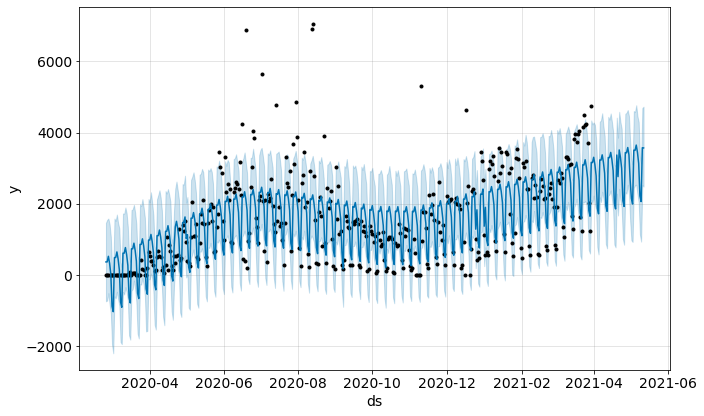

In [14]:
fig = modelo.plot(previsao, figsize=(10,6))


In [15]:
#Usando feriados especificos do municipio de SP

feriados_sp_2020 = [
'2020-02-25',
'2020-02-26',
'2020-04-10',
'2020-02-25',
'2020-02-26',
'2020-04-10',
'2020-04-21',
'2020-05-01',
'2020-05-20',
'2020-05-21', 
'2020-05-22',
'2020-05-25',
'2020-06-11',
'2020-09-07',
'2020-10-12',
'2020-11-02',
'2020-11-15',
'2020-12-25'
]

feriados_sp_2021 = [
'2021-01-01',
'2021-01-25',
'2021-02-15',
'2021-02-16',
'2021-02-17',
'2021-03-26',
'2021-03-29',
'2021-03-30',
'2021-03-31',
'2021-04-01',
'2021-04-02',
'2021-04-21',
'2021-05-01'
]

#Adicionar as listas ao DataFrame 
feriados_sp_2020 = pd.DataFrame({
  'holiday': 'sp_2020',
  'ds': pd.to_datetime(feriados_sp_2020)
})

feriados_sp_2021 = pd.DataFrame({
  'holiday': 'sp_2021',
  'ds': pd.to_datetime(feriados_sp_2021)
})

feriados = pd.concat((feriados_sp_2020, feriados_sp_2021)) #união das informações 

In [16]:
#Usando os feriados do município de SP

modelo_feriados = Prophet(n_changepoints = 25, changepoint_prior_scale=10.0, holidays=feriados)
modelo_feriados.fit(df)
dataframefuturo = modelo_feriados.make_future_dataframe(periods=36)
previsao = modelo_feriados.predict(dataframefuturo)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


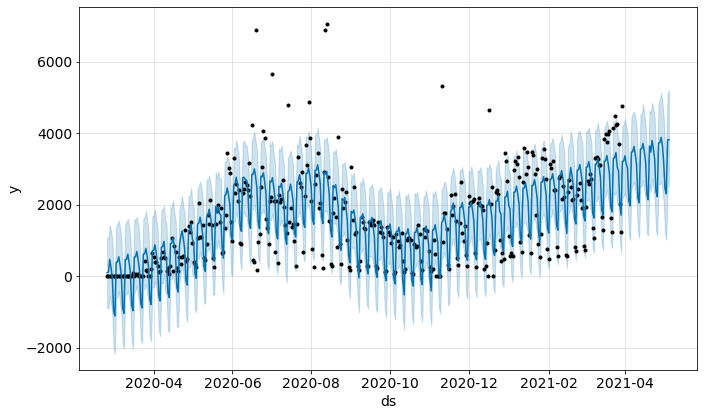

In [17]:
fig = modelo_feriados.plot(previsao, figsize=(10,6));

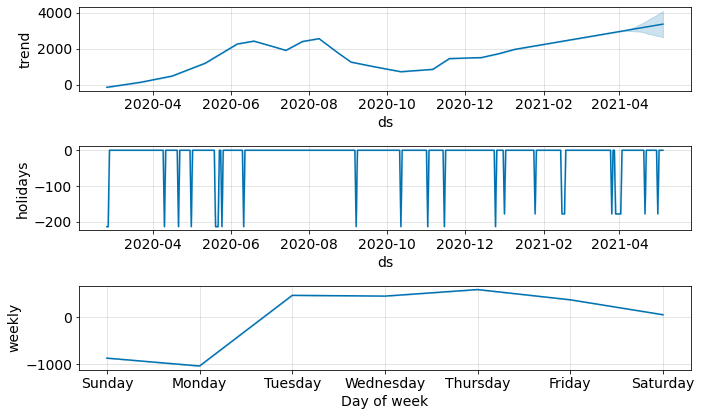

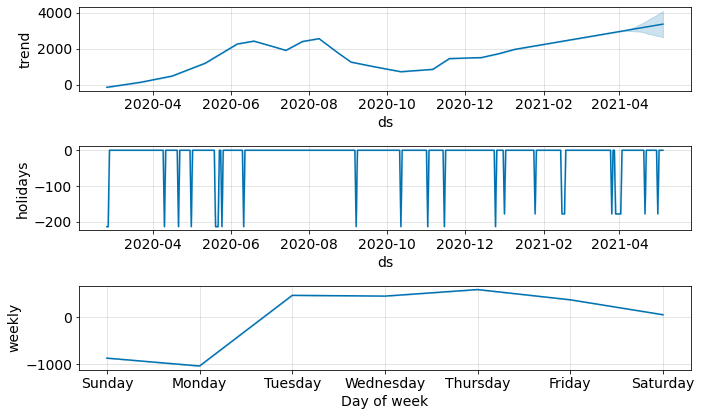

In [18]:

modelo.plot_components(previsao, figsize=(10,6))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


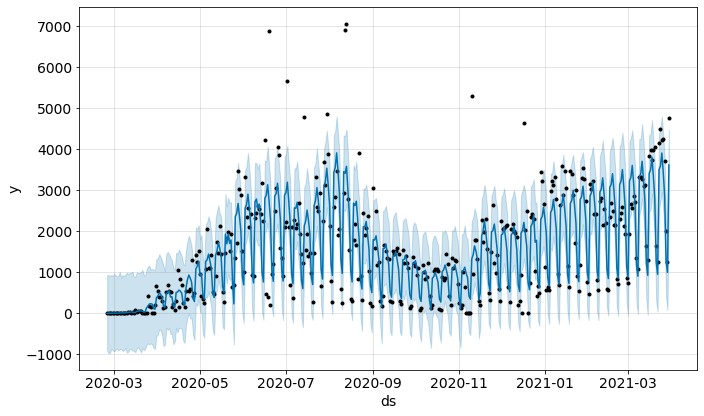

In [21]:
#Adicionando a sazonalidade:
modelo = Prophet(n_changepoints = 25 ,changepoint_prior_scale=10.0, seasonality_mode='multiplicative',holidays=feriados, weekly_seasonality=7)
modelo.fit(df)
dataframefuturo = modelo.make_future_dataframe(periods=0)
previsao = modelo.predict(dataframefuturo)
fig = modelo.plot(previsao, figsize=(10,6));

###**Tratamento de outliers**

Resetando o index:

In [22]:
novo_y = df.reset_index()

In [23]:
novo_y #novo dataframe com o index removido

,index,ds,y
0,562,2020-02-25,0
1,1207,2020-02-26,0
2,1852,2020-02-27,0
3,2497,2020-02-28,1
4,3142,2020-02-29,0
...,...,...,...
395,255337,2021-03-26,4241
396,255982,2021-03-27,3709
397,256627,2021-03-28,2010
398,257272,2021-03-29,1242


In [24]:
sem_outliers = novo_y[(novo_y['y']> previsao['yhat_lower'][:400]) & (novo_y['y'] < previsao['yhat_upper'][:400])]

In [25]:
sem_outliers

,index,ds,y
0,562,2020-02-25,0
1,1207,2020-02-26,0
2,1852,2020-02-27,0
3,2497,2020-02-28,1
4,3142,2020-02-29,0
...,...,...,...
394,254692,2021-03-25,4214
395,255337,2021-03-26,4241
396,255982,2021-03-27,3709
397,256627,2021-03-28,2010


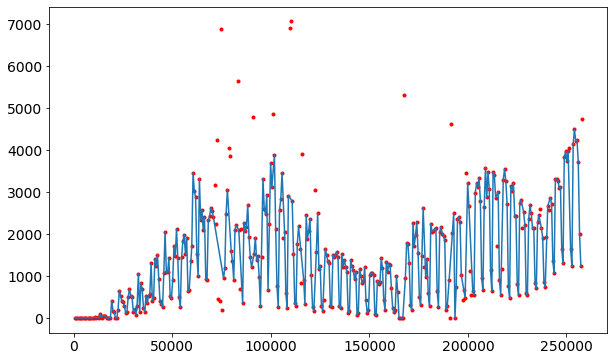

In [26]:
plt.plot(df.index, df['y'],'r.')
plt.plot(sem_outliers['index'], sem_outliers['y'])

Os pontos vermelhos são os dados anteriores à retirada dos outliers. Agora vamos analisar sem os outliers:

In [27]:
df_sem_outliers = sem_outliers[['ds','y']]

In [28]:
df_sem_outliers

,ds,y
0,2020-02-25,0
1,2020-02-26,0
2,2020-02-27,0
3,2020-02-28,1
4,2020-02-29,0
...,...,...
394,2021-03-25,4214
395,2021-03-26,4241
396,2021-03-27,3709
397,2021-03-28,2010


In [29]:
modelo = Prophet(n_changepoints = 25 ,changepoint_prior_scale=10.0, seasonality_mode='multiplicative', holidays=feriados, weekly_seasonality=7) #'multiplicative' 'additive'
modelo.fit(df_sem_outliers)
dataframefuturo = modelo.make_future_dataframe(periods=0)
previsao = modelo.predict(dataframefuturo)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


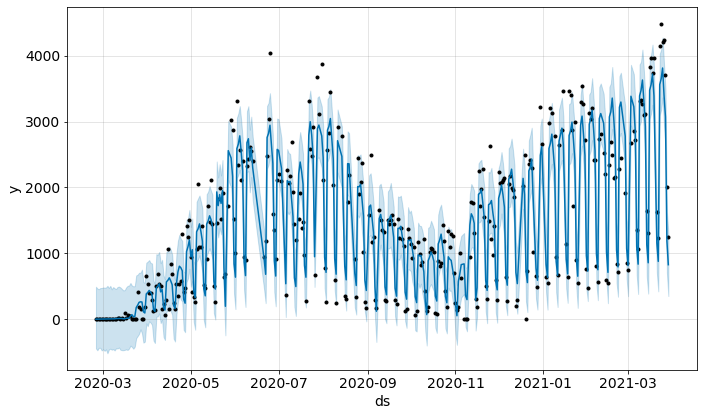

In [ ]:
fig = modelo.plot(previsao, figsize=(10,6));

Os outliers acabam enviesando negativamente as análises. 

O ajuste melhorou muito com a remoção dos outliers. 

Agora temos poucos dados fora da curva. 

###**Intervalo de Confiança**
O intervalo onde estão nossas possíveis soluções.

Gerando a análise com previsão:

In [30]:
modelo = Prophet(n_changepoints = 25 ,changepoint_prior_scale=10.0, seasonality_mode='multiplicative', holidays=feriados, weekly_seasonality=7) #'multiplicative' 'additive'
modelo.fit(df_sem_outliers)
dataframefuturo = modelo.make_future_dataframe(periods=43)
previsao = modelo.predict(dataframefuturo)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


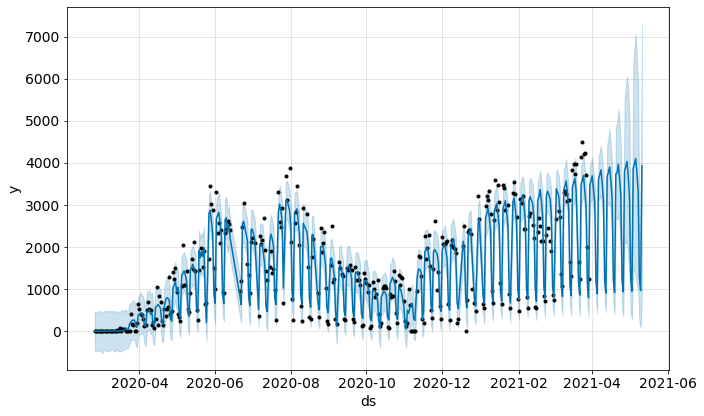

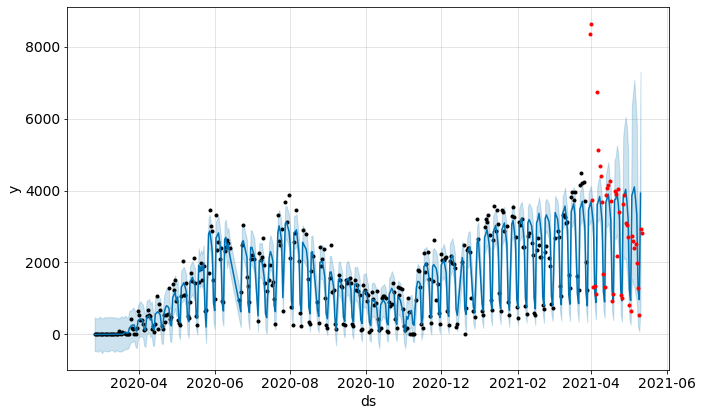

In [31]:
#sem dados de teste
fig = modelo.plot(previsao, figsize=(10,6));
plt.show()

#com os dados de teste
fig = modelo.plot(previsao, figsize=(10,6));
plt.plot(df_teste['ds'],df_teste['y'],'.r')

plt.show()

No teste a maioria dos pontos vermelhos está dentro do nosso modelo.

Análise dos componentes:

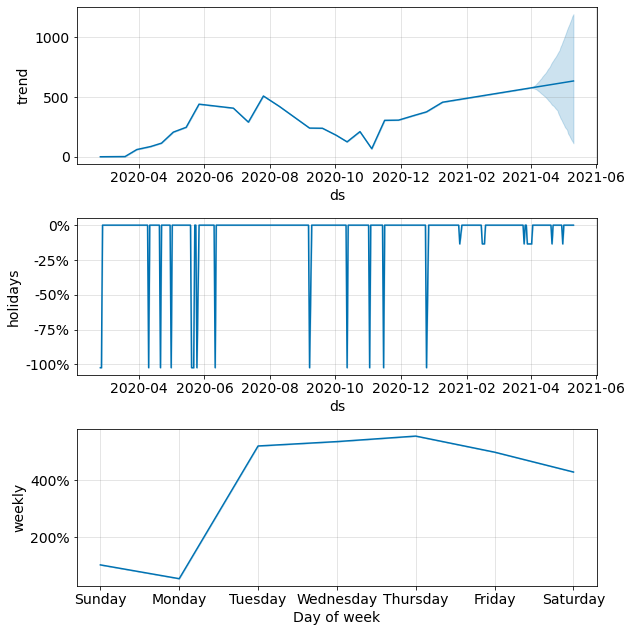

In [32]:
modelo.plot_components(previsao);

A linha de tendência está bem diferente agora em relação ao primeiro modelo, com algumas quebras.
Em holidays os feriados de 2021 tiveram menor impacto, pois os outliers foram retirados.


In [ ]:
amostras = modelo.predictive_samples(previsao)

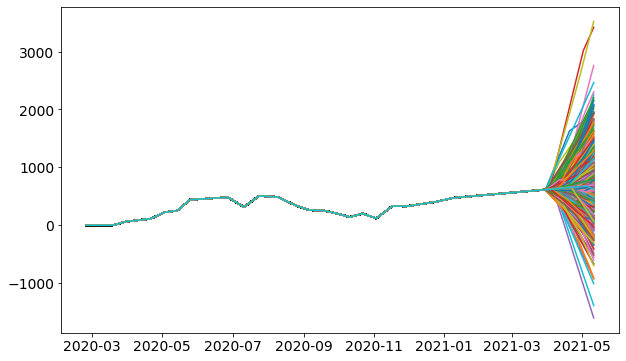

In [ ]:
plt.plot(previsao['ds'],amostras['trend']);

O ajuste do Prophet gera várias respostas de possíveis soluções.

###**Validação (Cross validation)** 

Quando vamos validar nosso modelo separamos os dados em treino, validação e teste. 

Os dados de treino são os que o modelo vai usar para se ajustar. Os de validação são os o que vamos usar para calcular a performance do modelo enquanto alterarmos variáveis como os hiperparâmetros. 

E por fim, depois de selecionarmos o modelo ideal usamos os dados de teste para calcular a métrica final do modelo.

Essa etapa de separação dos dados pode nos gerar uma limitação, pois vamos validar nossos dados apenas uma vez, já que não podemos prever dados que estavam no conjunto de dados de treino.

Para resolver isso surgiu a técnica Cross Validation ou CV que cria mais possibilidades de validação do nosso modelo com a mesma quantidade de dados que tínhamos antes. 

Em modelos de classificação, nossos dados podem estar embaralhados e a CV, neste caso, também minimiza o efeito da aleatoriedade dos dados utilizados para treinar o modelo, tendo assim, um resultado mais próximo do real.

In [ ]:
from fbprophet.diagnostics import cross_validation

Criar dataframe de validação cruzada:

O critério para essa divisão será definido através de alguns parâmetros:
- o primeiro é o `initial`, que define a porção inicial de dados que serão usados para o treinamento

- outro parâmetro de atenção é o `horizon` que é o horizonte, que é o tamanho da previsão que será feita

- o seguinte é o `period `que definimos de quanto em quanto tempo definimos um novo horizonte para prever.

In [ ]:
df_cv = cross_validation(modelo, initial='180 days', period='30 days', horizon = '30 days')


INFO:fbprophet:Making 7 forecasts with cutoffs between 2020-08-31 00:00:00 and 2021-02-27 00:00:00


Tivemos o parâmetro initial como 180 dias, isso significa que o primeiro grupo será treinando com 180 dias dos dados disponíveis, o parâmetro period com 30 dias indicando as divisões dos grupos será de 30 em 30 dias, o último é o parâmetro horizon que também é de 30 dias, indica que o modelo de cada grupo fará a previsão para 30 dias.

7 previões foram realizadas! 

A função `cross_validation` divide os dados em diversos grupos e consegue treinar e validar o modelo diversas vezes. 

In [ ]:
df_cv.head()
#cutoff onde começam os dados de teste

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-09-02,1902.867114,1479.700978,2366.273205,1579,2020-08-31
1,2020-09-03,2091.219221,1629.418092,2571.694354,2496,2020-08-31
2,2020-09-04,1909.729468,1407.053397,2463.722013,1166,2020-08-31
3,2020-09-05,1515.099544,943.634456,2090.040098,1245,2020-08-31
4,2020-09-06,630.776093,142.250311,1109.462608,290,2020-08-31


In [ ]:
df_cv['cutoff'].unique()

array(['2020-08-31T00:00:00.000000000', '2020-09-30T00:00:00.000000000',
       '2020-10-30T00:00:00.000000000', '2020-11-29T00:00:00.000000000',
       '2020-12-29T00:00:00.000000000', '2021-01-28T00:00:00.000000000',
       '2021-02-27T00:00:00.000000000'], dtype='datetime64[ns]')

Intervalos de 30 dias como teste, pula 30 dias e pega mais 30 dias teste...

In [ ]:
janela = 5 #mudar o valor da janela para verificar as janelas utilizadas para a validação dos resultados.

In [ ]:
cutoff = df_cv['cutoff'].unique()[janela]
df_cv_cut = df_cv[df_cv['cutoff'].values == cutoff]

Text(0.5, 0, 'ds')

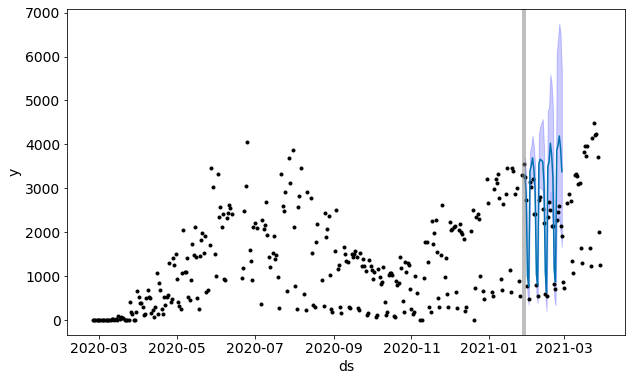

In [ ]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(modelo.history['ds'].values, modelo.history['y'], 'k.')
ax.plot(df_cv_cut['ds'].values, df_cv_cut['yhat'], ls='-', c='#0072B2')
ax.fill_between(df_cv_cut['ds'].values, df_cv_cut['yhat_lower'],
                df_cv_cut['yhat_upper'], color='blue',
                alpha=0.2)
ax.axvline(x=pd.to_datetime(cutoff), c='gray', lw=4, alpha=0.5)
ax.set_ylabel('y')
ax.set_xlabel('ds')

Cross validation é uma ferramenta estatística, que serve para saber o quanto nosso modelo está generalizando bem ou mal os nossos dados. 

- Em cinza temos o cuttoff

- A região em azul com intervalo de confiança é o trecho que foi usado pra teste. 


In [ ]:
from fbprophet.diagnostics import performance_metrics

In [ ]:
df_p = performance_metrics(df_cv)

INFO:fbprophet:Skipping MAPE because y close to 0


In [ ]:
df_p

,horizon,mse,rmse,mae,mdape,coverage
0,3 days,7.118691e+04,266.808744,199.699066,0.145585,0.888889
1,4 days,1.114484e+05,333.838955,265.742791,0.193123,0.833333
2,5 days,1.053426e+05,324.565185,261.138018,0.198963,0.880952
3,6 days,1.199638e+05,346.357922,284.249157,0.183555,0.796296
4,7 days,8.761803e+04,296.003432,248.594226,0.139623,0.833333
5,8 days,1.752461e+05,418.624037,340.227940,0.165147,0.666667
6,9 days,1.633391e+05,404.152336,321.925000,0.163146,0.722222
7,10 days,1.801642e+05,424.457498,360.125748,0.249301,0.755556
8,11 days,1.282918e+05,358.178439,319.904623,0.218112,0.904762
9,12 days,1.260677e+05,355.060094,290.336734,0.160994,0.904762


Algumas métricas são calculadas, medindo o quanto a nossa previsão está errando.

In [ ]:
from fbprophet.plot import plot_cross_validation_metric

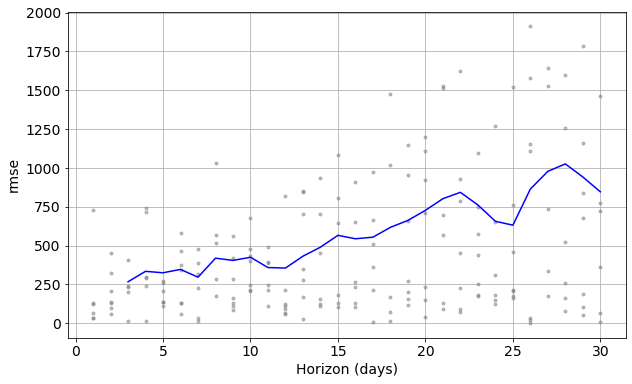

In [ ]:
fig = plot_cross_validation_metric(df_cv,metric='rmse') #rmse: erro médio quadrático. 

A ideia é ver se o cross validation está generalizando os dados.

Quanto menos disperso: melhor está sendo o nosso resultado!

##**Desafio 13: Testar diferentes intervalos de confiança.**

`interval_width=0.50`

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


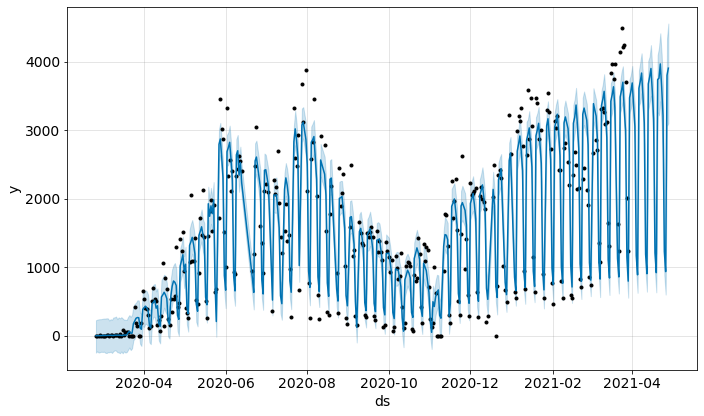

In [34]:
modelo = Prophet(interval_width=0.50, n_changepoints = 25 ,changepoint_prior_scale=10.0, 
                 seasonality_mode='multiplicative', holidays=feriados, weekly_seasonality=7) #'multiplicative' 'additive'
modelo.fit(df_sem_outliers)
dataframefuturo = modelo.make_future_dataframe(periods=30)
previsao = modelo.predict(dataframefuturo)
fig = modelo.plot(previsao, figsize=(10,6));

`interval_width=0.90`

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


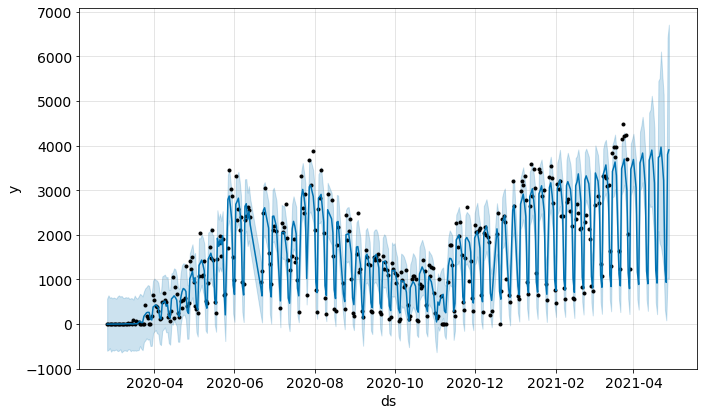

In [39]:
modelo = Prophet(interval_width=0.9, n_changepoints = 25 ,changepoint_prior_scale=10.0, 
                 seasonality_mode='multiplicative', holidays=feriados, weekly_seasonality=7) #'multiplicative' 'additive'
modelo.fit(df_sem_outliers)
dataframefuturo = modelo.make_future_dataframe(periods=30)
previsao = modelo.predict(dataframefuturo)
fig = modelo.plot(previsao, figsize=(10,6));

`interval_width=1`

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


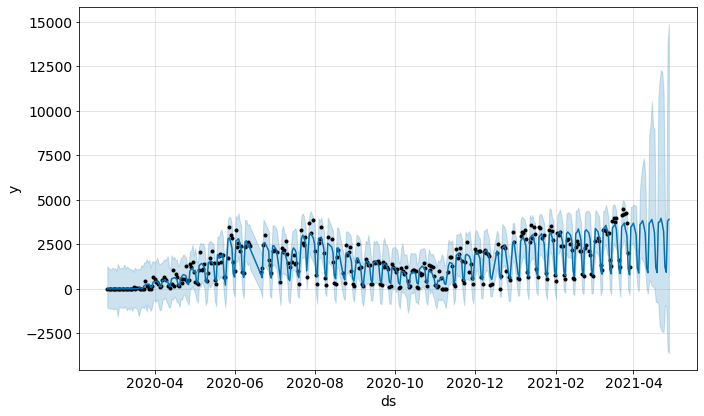

In [41]:
modelo = Prophet(interval_width=1, n_changepoints = 25 ,changepoint_prior_scale=10.0, 
                 seasonality_mode='multiplicative', holidays=feriados, weekly_seasonality=7) #'multiplicative' 'additive'
modelo.fit(df_sem_outliers)
dataframefuturo = modelo.make_future_dataframe(periods=30)
previsao = modelo.predict(dataframefuturo)
fig = modelo.plot(previsao, figsize=(10,6));

##**Desafio 14: Buscar quais métricas se aplicam a quais casos.**

##**Tipos de métricas**

**Erro Médio Absoluto - MAE**

O erro médio absoluto, MAE (da sigla em inglês Mean Absolute Error), é calculado a partir da média dos erros absolutos, ou seja, utilizamos o módulo de cada erro para evitar a subestimação, isso porque, o valor é menos afetado por pontos especialmente extremos (outliers).

Utilizamos essa medida em séries temporais, pois há casos em que o erro negativo pode zerar o positivo ou dar uma ideia de que o modelo é preciso. Mas aqui, medimos apenas a distância do valor real, independente de ser acima ou abaixo.


**Erro Quadrático Médio - MSE**

O erro quadrático médio, MSE (da sigla em inglês Mean Squared Error), é comumente usado para verificar a acurácia de modelos e dá um maior peso aos maiores erros, já que, ao ser calculado, cada erro é elevado ao quadrado individualmente e, após isso, a média desses erros quadráticos é calculada.

Por conta do expoente ao quadrado que o erro assume, essa métrica é bastante sensível a outliers (valores discrepantes) e, caso tenha muitos erros significativos em sua análise, essa métrica poderá ser extrapolada.


**Raiz Quadrada do Erro Médio - RMSE**

A raiz quadrada do erro médio, RMSE (da sigla em inglês Root Mean Squared Error) é apenas a raiz quadrada do MSE, onde o erro retorna à unidade de medida do modelo (no MSE, a unidade de medida é quadrática).
É frequentemente usada em séries temporais por ser mais sensível a erros maiores devido ao processo de quadratura que a produziu.

**Média Percentual Absoluta do Erro - MAPE**

Esta é outra métrica interessante para usar, geralmente usada em relatórios de gerenciamento, porque o erro é medido como uma porcentagem e assim, é possível fazer comparações entre erros percentuais do modelo entre produtos.

[Fonte](https://www.alura.com.br/artigos/metricas-de-avaliacao-para-series-temporais)

